In [ ]:
!pip install investpy
!pip install tqdm

In [1]:
import pandas as pd
import investpy
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
hoje = datetime.today().strftime('%d/%m/%Y')
hoje

'08/12/2020'

In [3]:
ticker_1 = 'PETR4' #óleo e gas
ticker_2 = 'MGLU3' #varejo

In [4]:
p1 = investpy.get_stock_historical_data(ticker_1, country='brazil',from_date='1/1/2019',to_date=hoje)['Close']
p2 = investpy.get_stock_historical_data(ticker_2, country='brazil',from_date='1/1/2019',to_date=hoje)['Close']

In [5]:
r = [] #lista contendo os retornos dos portfolios
σ = [] #lista contendo os riscos dos portfolios
for f in np.arange(0,1,0.01):
    portfolio = f * p1 + (1-f) * p2
    retorno_diario = portfolio.pct_change()
    r.append(100 * retorno_diario.mean())
    σ.append(100 * retorno_diario.std())

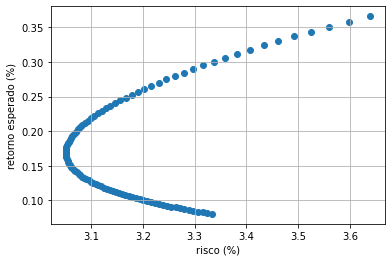

In [6]:
plt.scatter(σ, r)
plt.xlabel('risco (%)')
plt.ylabel('retorno esperado (%)')
plt.grid('on')
plt.show()

Cada ponto corresponde a uma carteira com frações diferentes de cada ação.  
Repare que existem duas carteiras com risco $3.2\%$.  
Tanto faz uma ou a outra?... ou nao?

E se tivermos mais do que duas ações? Tipo... 100?

### 3 ações

Antes de considerarmos 100 ações, vamos desenvolver nossa intuição olhando o que acontece com 3 ações.

In [7]:
ticker_3 = 'CYRE3' #construção

In [8]:
p3 = investpy.get_stock_historical_data(ticker_3, country='brazil',from_date='1/1/2019',to_date=hoje)['Close']

In [9]:
r12 = []
σ12 = []

r13 = []
σ13 = []

r23 = []
σ23 = []

for f in np.arange(0,1,0.01):
    
    #Portfolio 1-2
    
    portfolio = f * p1 + (1-f) * p2
    retorno_diario = portfolio.pct_change()
    r12.append(100 * retorno_diario.mean())
    σ12.append(100 * retorno_diario.std())
    
    #Portfolio 1-3
    
    portfolio = f * p1 + (1-f) * p3
    retorno_diario = portfolio.pct_change()
    r13.append(100 * retorno_diario.mean())
    σ13.append(100 * retorno_diario.std())
    
    #Portfolio 2-3
    
    portfolio = f * p2 + (1-f) * p3
    retorno_diario = portfolio.pct_change()
    r23.append(100 * retorno_diario.mean())
    σ23.append(100 * retorno_diario.std())


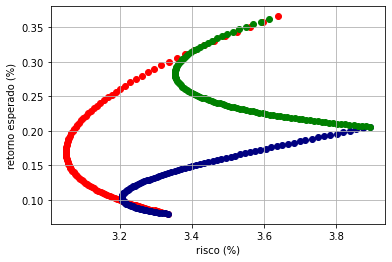

In [10]:
plt.scatter(σ12, r12, c = 'red')
plt.scatter(σ13, r13, c = 'navy')
plt.scatter(σ23, r23, c = 'green')
plt.xlabel('risco (%)')
plt.ylabel('retorno esperado (%)')
plt.grid('on')
plt.show()

Cada parábola corresponde a um par de ações.  
Cada ponto de uma parábola corresponde a diferentes proporções dessas ações.
Temos 3 ações, logo 3 pares possíveis, logo 3 parábolas.  

Repare que uma das parábolas _envolve_ as demais.  
Todas as parábolas _cabem dentro_ de uma parábola maior.  

Faz sentido comprar as ações das parábolas pequenininhas?

### Muitas ações

Vamos ver o que acontece se tivermos várias ações. 100.  

Esta função busca no _Investing.com_ 100 tickers de ações na bolsa de valores do Brasil.

In [11]:
tickers = investpy.get_stocks_overview(country='brazil', n_results=100).symbol

In [12]:
len(tickers)

100

Vamos buscar o preço dessas ações.  
Vamos considerar apenas ações com mais de 360 dias de negociação:

In [13]:
preco = {}
for t in tqdm(tickers):
    preco_da_acao = investpy.get_stock_historical_data(t, country='brazil',from_date='1/1/2019',to_date=hoje)['Close']
    if len(preco_da_acao) > 360: #Vamos considerar apenas ações negociadas a mais de 1 ano
        preco[t] = preco_da_acao

100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


Agora, vamos construir portfólios!  
Não conseguiremos construir todos os portfólios, porque são muitos: $\binom{100}{2} = 4950$ pares possiveis, cada par podendo ser formado com diferentes quantidades de uma ação ou outra.  

Então, vamos _gerar 10.000 portfólios aleatórios_:
* Sorteamos um par de ações
* Sorteamos quanto de cada ação terá no portfólio
* Calculamos o retorno esperado e o risco desse portfólio


In [14]:
len(preco)

91

In [15]:
tickers = list(preco.keys()) #atualizamos a lista com os tickers que de fato temos

In [16]:
numero_de_simulacoes = 10**4

output = {'acao_1':[],
          'acao_2':[],
          'fracao':[],
          'r':[],
          'σ':[]
         }

for simulacao in tqdm(range(numero_de_simulacoes)):
    #Escolha a ação
    acoes = np.random.choice(tickers, size=2, replace=False)
    acao_1 = acoes[0] #primeira ação
    acao_2 = acoes[1] #segunda ação
    
    #precos (series historicas)
    p1 = preco[acao_1] #preço da primeira ação
    p2 = preco[acao_2] #preço da segunda ação

    #Fação da primeira ação no portfólio
    f = np.random.random()
    
    output['acao_1'].append(acao_1)
    output['acao_2'].append(acao_2)
    output['fracao'].append(f)
        
    #Valor do portfolio (serie historica)
    portfolio = f * p1 + (1-f) * p2
        
    #Risco e retorno
    retorno_diario = portfolio.pct_change()
    output['r'].append(100 * retorno_diario.mean())    
    output['σ'].append(100 * retorno_diario.std())

100%|██████████| 10000/10000 [00:10<00:00, 932.31it/s]


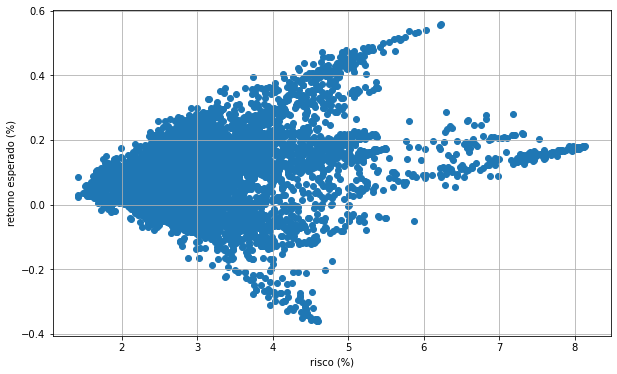

In [18]:
plt.figure(figsize=(10,6))
plt.scatter(output['σ'], output['r'])
plt.xlabel('risco (%)')
plt.ylabel('retorno esperado (%)')
plt.grid('on')
plt.show()

Você consegue enxergar a grande parábola onde cabem dentro todos os pontos?  

Escolha qualquer ponto fora dessa parábola. 
Investir nesse portfólio não vale a pena, porque você sempre consegue um outro portfólio com:
* Mais retorno e o mesmo nível de risco;
* Menos risco e o mesmo nível de retorno

Parabéns! Você acaba de descobrir a **Fronteira Eficiente de Markowitz**.

Por que isso é importante?

Digamos que eu aceite um nível de risco de até 5%. Que ações eu devo comprar para ter o maior retorno possível?

In [ ]:
import pandas as pd
df = pd.DataFrame(output)
df.head()

In [ ]:
df.loc[(df.σ < 5)].sort_values('r', ascending=False).head(1)

![markowitz-frontier](https://uk.scalable.capital/images/3x3i7a9xgm11/2s6len2dpSIM46oGkEQQ4A/5cb73a8b6812dc4b5a0621b57c6c3788/makowitz_efficient_frontier_hd-2.png)